In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [2]:
df = pd.read_excel("cleaned_josaa_data (1).xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82728 entries, 0 to 82727
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   82728 non-null  int64  
 1   round                  82728 non-null  int64  
 2   institute              82728 non-null  object 
 3   academic_program_name  82728 non-null  object 
 4   quota                  82728 non-null  object 
 5   seat_type              82728 non-null  object 
 6   gender                 82728 non-null  object 
 7   opening_rank           82728 non-null  float64
 8   closing_rank           82728 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 5.7+ MB


In [3]:
# Define target variable: Admission status
threshold = 10000  # Example: Consider closing rank <= 10000 as admitted
df['admission_status'] = (df['closing_rank'] <= threshold).astype(int)

# Drop unnecessary columns (year, round are not useful for prediction)
df.drop(columns=['year', 'round'], inplace=True)

In [4]:
categorical_columns = ['institute', 'academic_program_name', 'quota', 'seat_type', 'gender']
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

In [5]:
# Define features (X) and target (y)
X = df.drop(columns=['closing_rank', 'admission_status'])  # Exclude closing_rank from features
y = df['admission_status']

In [6]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Train Logistic Regression Model
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
y_proba_lr = model_lr.predict_proba(X_test)[:, 1]

In [8]:
# Train Random Forest Model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]


In [9]:
# Train Support Vector Classifier (SVC) Model
model_svc = SVC(kernel='rbf', probability=True, random_state=42)
model_svc.fit(X_train, y_train)
y_pred_svc = model_svc.predict(X_test)
y_proba_svc = model_svc.predict_proba(X_test)[:, 1]

In [10]:
# Evaluate Models
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.9684515895080382
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      4843
           1       0.97      0.98      0.98     11703

    accuracy                           0.97     16546
   macro avg       0.96      0.96      0.96     16546
weighted avg       0.97      0.97      0.97     16546



In [11]:
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9886981747854466
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4843
           1       0.99      0.99      0.99     11703

    accuracy                           0.99     16546
   macro avg       0.99      0.99      0.99     16546
weighted avg       0.99      0.99      0.99     16546



In [12]:
print("SVC Accuracy:", accuracy_score(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))

SVC Accuracy: 0.9647044602925178
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      4843
           1       0.97      0.98      0.98     11703

    accuracy                           0.96     16546
   macro avg       0.96      0.95      0.96     16546
weighted avg       0.96      0.96      0.96     16546



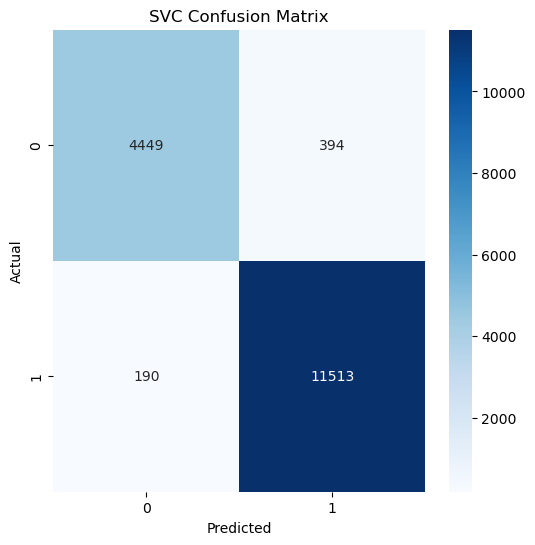

In [13]:
# Confusion Matrix
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_test, y_pred_svc), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVC Confusion Matrix")
plt.show()

In [14]:
# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_svc, tpr_svc, _ = roc_curve(y_test, y_proba_svc)
roc_auc_svc = auc(fpr_svc, tpr_svc)

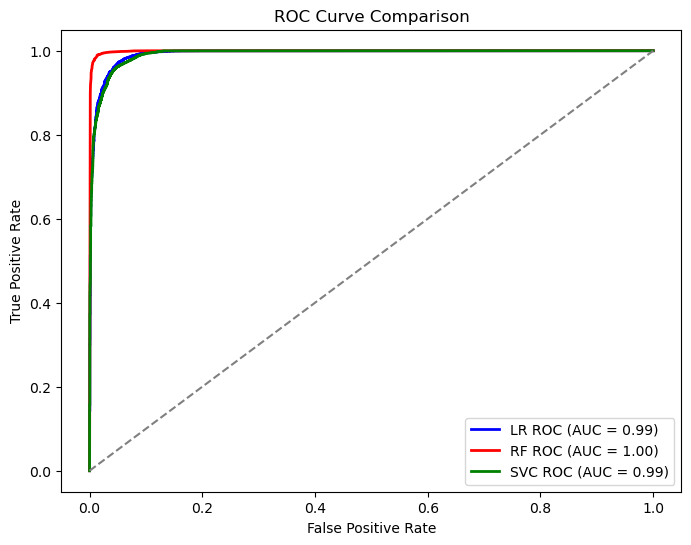

In [15]:
plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'LR ROC (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label=f'RF ROC (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_svc, tpr_svc, color='green', lw=2, label=f'SVC ROC (AUC = {roc_auc_svc:.2f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

In [16]:
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns,
    class_names=['class_0', 'class_1'],  # adjust based on your labels
    mode='classification'
)

# Explain one prediction
exp = explainer.explain_instance(X.iloc[0], model_svc.predict_proba)
exp.show_in_notebook()  # or exp.save_to_file('explanation.html')


c:\Users\dell\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\dell\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\dell\anaconda3\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

In [ ]:
import shap
import matplotlib.pyplot as plt

In [ ]:
# SHAP for Logistic Regression
explainer_logreg = shap.Explainer(model_lr, X_test)
shap_values_logreg = explainer_logreg(X_test)

# Summary Plot
shap.summary_plot(shap_values_logreg, X_test, plot_type="bar")

In [ ]:
# SHAP for Random Forest
explainer_rf = shap.TreeExplainer(model_rf)
shap_values_rf = explainer_rf.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values_rf[1], X_test)  # [1] = class 1 (admitted)

In [17]:
from sklearn.ensemble import VotingClassifier

# Define base models
rf_model = RandomForestClassifier()
lr_model = LogisticRegression(max_iter=1000)
svc_model = SVC(probability=True)

# Combine them using VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lr', lr_model),
        ('svc', svc_model)
    ],
    voting='soft'  # use probabilities
)

# Train
voting_clf.fit(X_train, y_train)

# Predict
y_pred = voting_clf.predict(X_test)
print("Ensemble Model Accuracy:", accuracy_score(y_test, y_pred))


Ensemble Model Accuracy: 0.9791490390426689


In [18]:
models = {
    "Random Forest": rf_model,
    "Logistic Regression": lr_model,
    "SVC": svc_model,
    "Voting Ensemble": voting_clf
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"{name}: Accuracy = {acc:.2f}")

Random Forest: Accuracy = 0.99
Logistic Regression: Accuracy = 0.97
SVC: Accuracy = 0.96
Voting Ensemble: Accuracy = 0.98


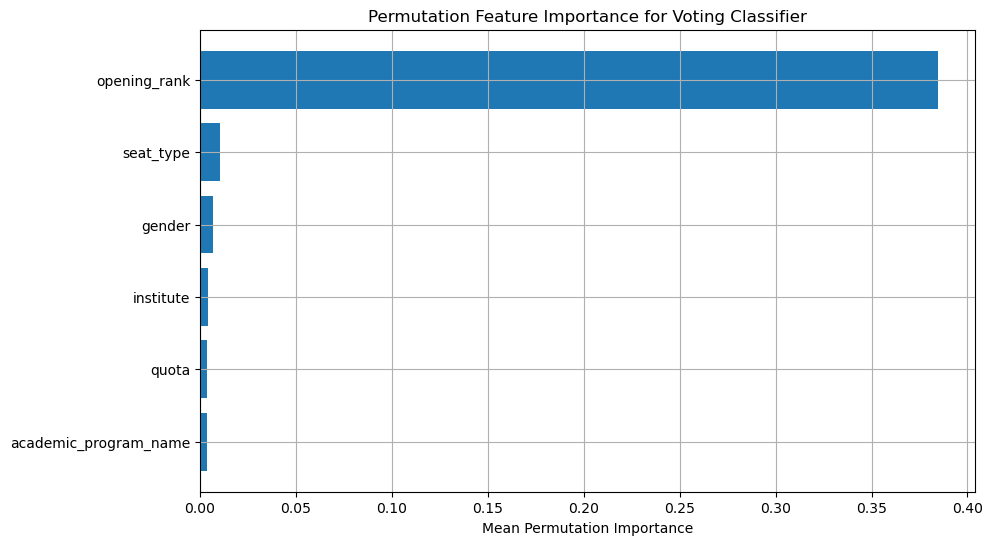

In [19]:
# Required Libraries
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Assume your voting classifier is trained as 'voting_clf'
# Example: voting_clf.fit(X_train, y_train)

# Step 1: Apply Permutation Importance
result = permutation_importance(
    voting_clf,          # Your trained model
    X_test,              # Features on test data
    y_test,              # True labels on test data
    n_repeats=30,        # Number of times to shuffle a feature
    random_state=42,     # For reproducibility
    n_jobs=-1            # Use all CPU cores
)

# Step 2: Extract importance scores
importance_means = result.importances_mean
feature_names = X_test.columns  # If using pandas DataFrame

# Step 3: Sort features by importance
sorted_idx = np.argsort(importance_means)

# Step 4: Plot Permutation Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], importance_means[sorted_idx])
plt.xlabel("Mean Permutation Importance")
plt.title("Permutation Feature Importance for Voting Classifier")
plt.grid(True)
plt.show()


In [1]:
import joblib
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Load data again (make sure fresh start)
df = pd.read_excel("cleaned_josaa_data (1).xlsx")

# Encode categorical columns
categorical_columns = ['institute', 'academic_program_name', 'quota', 'seat_type', 'gender']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define features and target
X = df.drop(columns=['year', 'round', 'closing_rank'])
y = (df['opening_rank'] <= 10000).astype(int)

# Train models
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X, y)

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X, y)

model_svc = SVC(kernel='rbf', probability=True, random_state=42)
model_svc.fit(X, y)

voting_clf = VotingClassifier(
    estimators=[
        ('rf', model_rf),
        ('lr', model_lr),
        ('svc', model_svc)
    ],
    voting='soft'
)
voting_clf.fit(X, y)

# Create models dictionary
models = {
    "logistic_regression": model_lr,
    "random_forest": model_rf,
    "svc": model_svc,
    "voting_classifier": voting_clf
}

# Save all models
import os
os.makedirs('models', exist_ok=True)

for name, model in models.items():
    joblib.dump(model, f"models/{name}.pkl")

# Save label encoders
joblib.dump(label_encoders, "models/label_encoders.pkl")

print("✅ All models and encoders saved successfully!")


✅ All models and encoders saved successfully!


In [4]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import shap  
import lime

C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


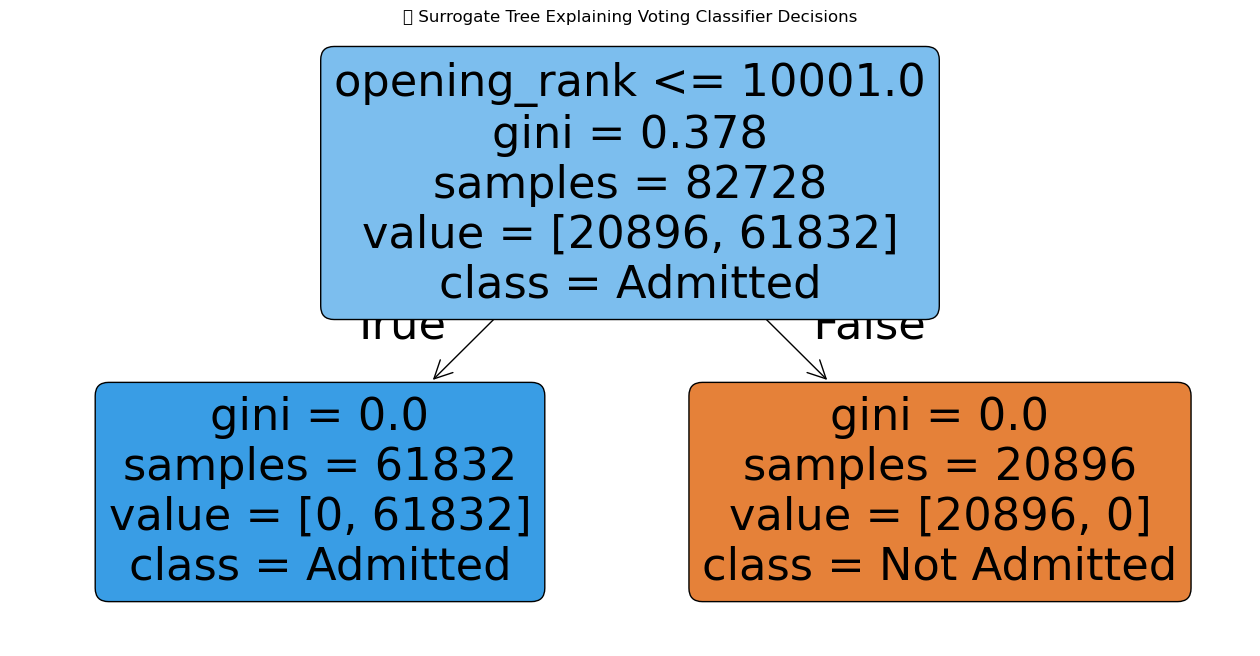

In [2]:
# Load saved Voting Classifier
model = joblib.load("models/voting_classifier.pkl")

# Load and preprocess data (already encoded + cleaned version)
df = pd.read_excel("cleaned_josaa_data (1).xlsx")

# Encode categorical columns again (must match training time)
from sklearn.preprocessing import LabelEncoder
categorical_columns = ['institute', 'academic_program_name', 'quota', 'seat_type', 'gender']
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Define features
X = df.drop(columns=['year', 'round', 'closing_rank'])
y = (df['opening_rank'] <= 10000).astype(int)

# Use the voting classifier to get predicted labels
y_pred_by_model = model.predict(X)

# Train a shallow surrogate decision tree
surrogate = DecisionTreeClassifier(max_depth=3, random_state=42)
surrogate.fit(X, y_pred_by_model)

# Plot the surrogate tree
plt.figure(figsize=(16, 8))
plot_tree(
    surrogate,
    feature_names=X.columns,
    class_names=["Not Admitted", "Admitted"],
    filled=True,
    rounded=True
)
plt.title("🧠 Surrogate Tree Explaining Voting Classifier Decisions")
plt.show()


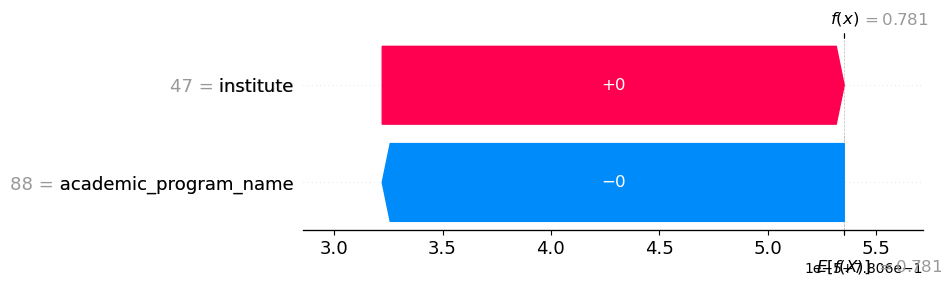

In [8]:
import shap
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load model
model = joblib.load("models/voting_classifier.pkl")

# Load and encode data
df = pd.read_excel("cleaned_josaa_data (1).xlsx")
categorical_columns = ['institute', 'academic_program_name', 'quota', 'seat_type', 'gender']
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Prepare features
X = df.drop(columns=['year', 'round', 'closing_rank'])
X_sample = X.iloc[[15]]  # ✅ Must be DataFrame with shape (1, n_features)
X_background = X.sample(100, random_state=42)

# SHAP for VotingClassifier (model.predict_proba returns 2-class output)
explainer = shap.Explainer(model.predict_proba, X_background)
shap_values = explainer(X_sample)  # Output shape: (1, 2, n_features)

# ✅ Choose class 1 explanation (Admitted)
shap.plots.waterfall(shap.Explanation(
    values=shap_values.values[0, 1],
    base_values=shap_values.base_values[0, 1],
    data=shap_values.data[0],
    feature_names=shap_values.feature_names
))


In [12]:
import numpy as np
# Load model
model = joblib.load("models/voting_classifier.pkl")

# Load and encode data
df = pd.read_excel("cleaned_josaa_data (1).xlsx")
categorical_columns = ['institute', 'academic_program_name', 'quota', 'seat_type', 'gender']
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Prepare features
X = df.drop(columns=['year', 'round', 'closing_rank'])
X_background = X.sample(100, random_state=42)
X_sample = X.iloc[[15]]  # Choose the row you want to explain

# SHAP explanation for voting classifier
explainer = shap.Explainer(model.predict_proba, X_background)
shap_values = explainer(X_sample)

# Extract explanation for class 1 (Admitted)
explanation = shap.Explanation(
    values=shap_values.values[0, 1],
    base_values=shap_values.base_values[0, 1],
    data=shap_values.data[0],
    feature_names=shap_values.feature_names
)

# Generate custom rule-like text
print("\n📘 Rule-Based Explanation for Student #15:\n")

# Sort features by absolute SHAP value
feature_impact = sorted(
    zip(explanation.feature_names, explanation.values, explanation.data),
    key=lambda x: abs(x[1]),
    reverse=True
)

# Display top 3 rules
for i, (name, shap_val, value) in enumerate(feature_impact[:3]):
    direction = "increase" if shap_val > 0 else "decrease"
    effect = "increases" if shap_val > 0 else "decreases"
    print(f"- {name} = {value} → {effect} the chance of admission")
    print(f"  Suggestion: Try to {direction} or improve this feature if possible.\n")

proba = model.predict_proba(X_sample)[0][1]
print(f"Final Admission Probability: {proba:.2f}")




📘 Rule-Based Explanation for Student #15:

- institute = 47.0 → increases the chance of admission
  Suggestion: Try to increase or improve this feature if possible.

- academic_program_name = 88.0 → decreases the chance of admission
  Suggestion: Try to decrease or improve this feature if possible.

Final Admission Probability: 1.00
